In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.covariance import MinCovDet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib.ticker import FormatStrFormatter


<h3>Optimising cutoff radii</h3>

In [110]:
df_validation = pd.read_csv('BOWSR_validation_atom_radii_2_metal.csv')

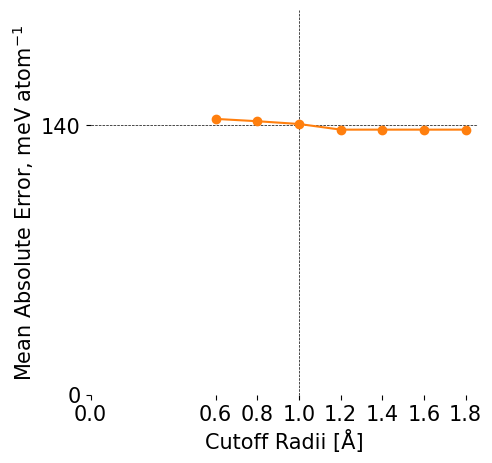

In [128]:
numeric_columns = ['0.6', '0.8', '1', '1.2', '1.4', '1.6', '1.8']
df_numeric = df_validation[numeric_columns ]

# Calculate mean and standard deviation for each hyperparameter based on 'metal_amount'
means = df_numeric[numeric_columns].mean() * 1000
# stds = df_numeric[numeric_columns].std() * 1000 

x = np.arange(0.6, 2, 0.2)
fig, ax = plt.subplots(figsize=(5, 5))

plt.errorbar(x, means, fmt='-o', color = 'C1')
ax.tick_params(which='major', labelsize=15)
ax.set_xlabel('Cutoff Radii [Å]', fontsize=15)
ax.set_ylabel(r'Mean Absolute Error, meV atom$^{-1}$', fontsize=15)
ax.set_ylim(0, 200)
plt.yticks([0, 140])
plt.xticks([0, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
plt.box(False)
plt.axhline(140, color='black', linestyle='--', linewidth=0.5)
plt.axvline(1, color='black', linestyle='--', linewidth=0.5)
plt.show()


<h3>Benchmarking values from MP with those obtaines by MEGNet</h3>

In [112]:
df_MEGNET = pd.read_csv('BOWSR_300_2_metal_1A.csv')

In [113]:
df_Hd = pd.read_csv('300_materials_Hd.csv')

R-squared: 0.9896640040886158
Mean Squared Error: 0.003160462748613709
Mean Absolute Error: 0.04053967268715345
R-squared: 0.932064839260571


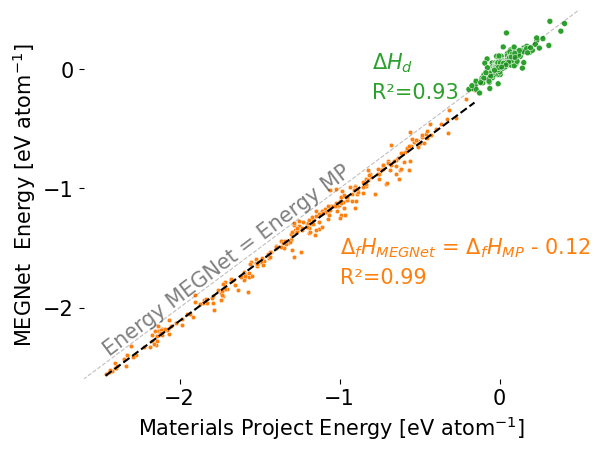

In [117]:
plt.figure()

mean = np.mean(df_MEGNET['error'])
std_dev = np.std(df_MEGNET['error'])

# Define threshold for outliers (3 sigma)
threshold = 3 * std_dev

# Detect outliers
outliers_mask = np.abs(df_MEGNET['error'] - mean) > threshold

df_filtered = df_MEGNET[~outliers_mask]

model = LinearRegression().fit(df_filtered['formation_energy_per_atom, MP'].values.reshape(-1, 1),
                                df_filtered['Ef(MEGNET), eV/atom'].values.reshape(-1, 1))

y_pred = model.predict(df_filtered['formation_energy_per_atom, MP'].values.reshape(-1, 1))

# Calculate the slope and intercept of the linear regression line

slope = float(model.coef_[0])
intercept = float(model.intercept_)

# Calculate the y=x line
y_equals_x = df_MEGNET['formation_energy_per_atom, MP']


r2 = r2_score(df_filtered['Ef(MEGNET), eV/atom'], y_pred.flatten())
print(f'R-squared: {r2}')

mse = mean_squared_error(df_filtered['Ef(MEGNET), eV/atom'], y_pred.flatten())
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(df_filtered['Ef(MEGNET), eV/atom'], y_pred.flatten())
print(f'Mean Absolute Error: {mae}')

model_Hd = LinearRegression().fit(df_Hd['Hd_MP'].values.reshape(-1, 1),
                                df_Hd['Hd_MEGNET'].values.reshape(-1, 1))

y_pred_Hd = model_Hd.predict(df_Hd['Hd_MP'].values.reshape(-1, 1))

# Calculate the slope and intercept of the linear regression line

slope_Hd = float(model_Hd.coef_[0])
intercept_Hd = float(model_Hd.intercept_)

r2_Hd = r2_score(df_Hd['Hd_MP'], y_pred_Hd.flatten())
print(f'R-squared: {r2_Hd}')

#Formation energy plot
g = sns.scatterplot(data=df_filtered, 
                x='formation_energy_per_atom, MP', 
                y='Ef(MEGNET), eV/atom', 
                color='C1', 
                s=10)
#Decomposition energy plot
sns.scatterplot(data=df_Hd, 
                x=f'Hd_MP',
                y=f'Hd_MEGNET', 
                size=2, 
                zorder=2, 
                color = 'C2')

# Plot line y=x
plt.plot([-2.75, 1], [-2.75, 1], '--', color='black', alpha=0.25, linewidth=0.8)

# Plot linear regression line
g1 = sns.lineplot(x=df_filtered['formation_energy_per_atom, MP'], y=y_pred.flatten(),
             color='black', linestyle='--', label=f'y(x) = {slope:.2f} * x + {intercept:.2f}', ax=g)

Ef_MEGNET = r'$\it{\Delta}_f{H}_\mathrm{\mathit{MEGNet}}$'
Ef_MP = r'$\it{\Delta}_f{H}_\mathrm{\mathit{MP}}$'

plt.text(-2.5,-2.4,f'Energy MEGNet = Energy MP', color='black', alpha=0.5, size=15, rotation=37)
plt.text(-1,-1.55,f'{Ef_MEGNET} = {Ef_MP} - {abs(intercept):.2f}', color='C1', size=15)
plt.text(-1,-1.8,f'R²={r2:.2f}', color='C1', size=15)
plt.text(-0.8, 0, r'$\it{\Delta}H_\mathrm{\mathit{d}}$',fontsize=15, color='C2')
plt.text(-0.8,-0.25,f'R²={r2_Hd:.2f}', color='C2', size=15)
plt.tick_params(which='major', labelsize=15)
plt.xlabel(r'Materials Project Energy [eV atom$^{-1}$]', fontsize=15)
plt.ylabel(r'MEGNet  Energy [eV atom$^{-1}$]', fontsize=15)
plt.box(False)
plt.yticks([0.0, -1.0, -2.0])
plt.xticks([0.0, -1.0, -2.0])
plt.xlim(-2.6, 0.5)
plt.ylim(-2.6, 0.5)
plt.legend().set_visible(False)    
plt.show()
outliers_indices = df_MEGNET.index[outliers_mask]

#     # Delete rows with outliers from df_MEGNET
df_MEGNET.drop(outliers_indices, inplace=True)




<h3>Add corection to MEGNet formation energies and plot distribution of absolute errors</h3>

In [120]:
df_MEGNET['Ef_megnet_corrected'] = df_MEGNET['Ef(MEGNET), eV/atom'] + 0.12 
df_MEGNET['Absolute_error'] = (abs(df_MEGNET['Ef_megnet_corrected'] - df_MEGNET['formation_energy_per_atom, MP']))*1000
df_Hd['Absolute_error_Hd'] = (abs(df_Hd['Hd_MP'] - df_Hd['Hd_MEGNET']))*1000


mean_Ef = df_MEGNET['Absolute_error'].mean()
mean_Hd = df_Hd['Absolute_error_Hd'].mean()

In [121]:
df_MEGNET.to_csv('BOWSR_300_materials_2_material_1A_new.csv')

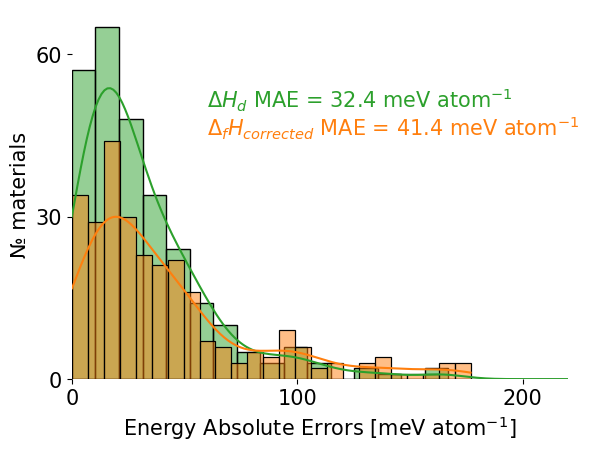

In [125]:
g = sns.histplot(data=df_Hd, x=f'Absolute_error_Hd', kde=True, color='C2',
                 bins=25
                )
g = sns.histplot(data=df_MEGNET, x=f'Absolute_error', kde=True, color='C1',
                 bins=25
                )

plt.text(60, 45, r'$\it{\Delta}_fH_{corrected}$ MAE = ' + f'{mean_Ef:.1f}'+r' meV atom$^{-1}$',
         fontsize=15, 
         color='C1')
plt.text(60, 50, r'$\it{\Delta}H_\mathrm{\mathit{d}}$ MAE = ' + f'{mean_Hd:.1f}'+r' meV atom$^{-1}$',
         fontsize=15, 
         color='C2')

plt.yticks([0,30,60])
plt.xticks([0,100, 200])
plt.xlim(0,220)
plt.xlabel(r'Energy Absolute Errors [meV atom$^{-1}$]',fontsize=15)
plt.ylabel(r'№ materials',fontsize=15)
plt.tick_params(which='major', labelsize=15)
plt.box(False)
plt.show()